# §7.1 Catastrophic Forgetting as $\Sigma\mathrm{W}$ Degradation
## Computational Grounding for the $\Sigma$-Semantic Normal Form

**Purpose.** This notebook demonstrates that the degradation theory (Props 4.2–4.4, Cor 4.4.1) captures the mechanism of catastrophic forgetting: when a system trained on Task A switches to Task B, the semantic closure ($\Sigma\mathrm{W}$) established during Task A is destroyed at the rate predicted by $D_\Sigma$.

**Structure.**
- Experiment 1: Task transition → $\mathcal{B}_\Sigma$ destruction, $\eta \cdot D_\Sigma$ prediction
- Experiment 2: $D_\Sigma$ prediction accuracy across scales ($N$, $|S|$)
- Experiment 3: $\mathcal{L}_\Sigma$ regularization suppresses forgetting (EWC correspondence)
- Experiment 4: Multi-step accumulation bound (Corollary 4.4.1)

In [1]:
# ============================================================================
# Imports and utility functions (from sigma_snf_validation.ipynb)
# ============================================================================

from typing import Dict, List
import numpy as np

try:
    import matplotlib.pyplot as plt
except Exception:
    plt = None

Partition = Dict[int, str]


def build_fibers(partition: Partition, n_states: int) -> Dict[str, List[int]]:
    labels = sorted(set(partition.values()))
    fibers: Dict[str, List[int]] = {label: [] for label in labels}
    for s in range(n_states):
        fibers[partition[s]].append(s)
    return fibers


def block_pushforward(P: np.ndarray, partition: Partition, state: int) -> np.ndarray:
    labels = sorted(set(partition.values()))
    fibers = build_fibers(partition, P.shape[0])
    return np.array([P[state, fibers[label]].sum() for label in labels], dtype=float)


def block_sum_spread(P: np.ndarray, partition: Partition) -> float:
    n = P.shape[0]
    fibers = build_fibers(partition, n)
    labels = sorted(fibers.keys())
    max_diff = 0.0
    for label, states in fibers.items():
        for i_idx in range(len(states)):
            for j_idx in range(i_idx + 1, len(states)):
                i = states[i_idx]
                j = states[j_idx]
                for t_label in labels:
                    t_states = fibers[t_label]
                    diff = abs(P[i, t_states].sum() - P[j, t_states].sum())
                    max_diff = max(max_diff, diff)
    return float(max_diff)


def tv_violation(P: np.ndarray, partition: Partition) -> float:
    n = P.shape[0]
    fibers = build_fibers(partition, n)
    max_tv = 0.0
    for label, states in fibers.items():
        for i_idx in range(len(states)):
            for j_idx in range(i_idx + 1, len(states)):
                i = states[i_idx]
                j = states[j_idx]
                p_i = block_pushforward(P, partition, i)
                p_j = block_pushforward(P, partition, j)
                tv = 0.5 * np.abs(p_i - p_j).sum()
                max_tv = max(max_tv, tv)
    return float(max_tv)


def softmax_rows(theta: np.ndarray) -> np.ndarray:
    shifted = theta - theta.max(axis=1, keepdims=True)
    e = np.exp(shifted)
    return e / e.sum(axis=1, keepdims=True)


def theta_from_P(P: np.ndarray, eps: float = 1e-15) -> np.ndarray:
    return np.log(np.maximum(P, eps))


def numerical_gradient(loss_fn, theta: np.ndarray, eps: float = 1e-6) -> np.ndarray:
    grad = np.zeros_like(theta)
    for i in range(theta.shape[0]):
        for j in range(theta.shape[1]):
            theta[i, j] += eps
            fp = loss_fn(theta)
            theta[i, j] -= 2.0 * eps
            fm = loss_fn(theta)
            theta[i, j] += eps
            grad[i, j] = (fp - fm) / (2.0 * eps)
    return grad


def make_weak_sigmaw(partition: Partition, P_hat: np.ndarray, rng: np.random.Generator) -> np.ndarray:
    n = len(partition)
    labels = sorted(set(partition.values()))
    fibers = build_fibers(partition, n)
    P = np.zeros((n, n), dtype=float)
    for i in range(n):
        b_i = labels.index(partition[i])
        for b_j, label in enumerate(labels):
            states = fibers[label]
            w = rng.dirichlet(np.ones(len(states)))
            for k, s in enumerate(states):
                P[i, s] = P_hat[b_i, b_j] * w[k]
    return P


def compute_lumped_chain(P: np.ndarray, partition: Partition) -> np.ndarray:
    labels = sorted(set(partition.values()))
    fibers = build_fibers(partition, P.shape[0])
    m = len(labels)
    out = np.zeros((m, m), dtype=float)
    for i, l_from in enumerate(labels):
        for j, l_to in enumerate(labels):
            vals = [P[s, fibers[l_to]].sum() for s in fibers[l_from]]
            out[i, j] = float(np.mean(vals))
    return out


def sigmaw_symmetric_loss_factory(partition: Partition, target_hat: np.ndarray):
    def loss_fn(P: np.ndarray) -> float:
        P_hat = compute_lumped_chain(P, partition)
        return float(((P_hat - target_hat) ** 2).sum())
    return loss_fn


def gamma_from_theta_grad(theta: np.ndarray, grad: np.ndarray, partition: Dict[int, str]) -> float:
    P0 = softmax_rows(theta)
    labels = sorted(set(partition.values()))
    fibers = {label: [s for s in range(P0.shape[0]) if partition[s] == label] for label in labels}
    G_bar = (P0 * grad).sum(axis=1)
    A = np.zeros((P0.shape[0], len(labels)), dtype=float)
    for s_idx, label in enumerate(labels):
        for k in fibers[label]:
            A[:, s_idx] += P0[:, k] * (grad[:, k] - G_bar)
    gamma = 0.0
    for label in labels:
        states = fibers[label]
        for i_idx in range(len(states)):
            for j_idx in range(i_idx + 1, len(states)):
                i = states[i_idx]
                j = states[j_idx]
                gamma = max(gamma, np.abs(A[i] - A[j]).max())
    return float(gamma)


def degradation_rate_gamma(theta: np.ndarray, loss_fn_P, partition: Partition) -> float:
    grad = numerical_gradient(lambda th: loss_fn_P(softmax_rows(th)), theta)
    return gamma_from_theta_grad(theta, grad, partition)


def _labels(n_blocks: int) -> List[str]:
    if n_blocks <= 26:
        return [chr(ord('A') + i) for i in range(n_blocks)]
    return [f'B{i}' for i in range(n_blocks)]


def balanced_partition(n_states: int, n_blocks: int) -> Dict[int, str]:
    labels = _labels(n_blocks)
    return {i: labels[i % n_blocks] for i in range(n_states)}


def smooth_sigmaw_violation(P: np.ndarray, partition: Partition) -> float:
    """Definition 4.8: differentiable L_Sigma violation."""
    n = P.shape[0]
    fibers = build_fibers(partition, n)
    labels = sorted(fibers.keys())
    total = 0.0
    for label_from, states in fibers.items():
        for i_idx in range(len(states)):
            for j_idx in range(i_idx + 1, len(states)):
                i = states[i_idx]
                j = states[j_idx]
                for label_to in labels:
                    t_states = fibers[label_to]
                    diff = P[i, t_states].sum() - P[j, t_states].sum()
                    total += diff ** 2
    return float(total)


print('Utilities loaded.')

Utilities loaded.


---
## Experiment 1: Task Transition Destroys $\Sigma\mathrm{W}$

**Setup.** Train on Task A ($\Sigma\mathrm{W}$-symmetric loss) from block-constant $\theta_0$ → $\Sigma\mathrm{W}$ preserved (Prop 4.2). Switch to Task B (non-$\Sigma\mathrm{W}$-symmetric loss) → $\Sigma\mathrm{W}$ breaks at rate $\eta \cdot D_\Sigma$ (Prop 4.3–4.4).

This is the Markov-chain analogue of catastrophic forgetting: the semantic structure learned for Task A is destroyed by gradient updates toward Task B.

In [2]:
# ── Experiment 1: Task A → Task B transition ──

rng = np.random.default_rng(42)
N, n_blocks = 6, 2
part = balanced_partition(N, n_blocks)
eta = 0.01

# Task A: ΣW-symmetric loss (depends only on lumped chain P_hat)
P_hat_A = np.array([[0.7, 0.3], [0.4, 0.6]], dtype=float)
task_A_loss = sigmaw_symmetric_loss_factory(part, P_hat_A)

# Task B: non-ΣW-symmetric loss (depends on individual P entries)
P_target_B = rng.dirichlet(np.ones(N), size=N)  # random target — NOT ΣW
def task_B_loss(P: np.ndarray) -> float:
    return float(((P - P_target_B) ** 2).sum())

# Phase 1: Train on Task A from block-constant init (Prop 4.2 → ΣW preserved)
theta = np.zeros((N, N), dtype=float)
# Make block-constant: same logits within each fiber
fibers = build_fibers(part, N)
for label, states in fibers.items():
    row_val = rng.normal(size=N) * 0.5
    for s in states:
        theta[s] = row_val.copy()

T_A = 300
bsigma_phase1 = []
for t in range(T_A):
    P = softmax_rows(theta)
    bsigma_phase1.append(block_sum_spread(P, part))
    grad = numerical_gradient(lambda th: task_A_loss(softmax_rows(th)), theta)
    theta = theta - eta * grad

P_after_A = softmax_rows(theta)
print(f'Phase 1 (Task A, {T_A} steps):')
print(f'  B_Σ at start : {bsigma_phase1[0]:.2e}')
print(f'  B_Σ at end   : {bsigma_phase1[-1]:.2e}')
print(f'  ΣW preserved : {bsigma_phase1[-1] < 1e-10}')
print(f'  Lumped chain :\n{compute_lumped_chain(P_after_A, part)}')

# Compute D_Σ at transition point (Prop 4.4)
D_sigma = degradation_rate_gamma(theta, task_B_loss, part)
print(f'\nD_Σ at transition: {D_sigma:.6e}')
print(f'Predicted first-step B_Σ = η·D_Σ = {eta * D_sigma:.6e}')

# Phase 2: Switch to Task B → ΣW breaks
T_B = 100
bsigma_phase2 = []
d_sigma_per_step = []

for t in range(T_B):
    P = softmax_rows(theta)
    bsigma_phase2.append(block_sum_spread(P, part))
    # Track D_Σ at each step
    if t < 10:  # first 10 steps for detailed tracking
        d_sigma_per_step.append(degradation_rate_gamma(theta, task_B_loss, part))
    grad = numerical_gradient(lambda th: task_B_loss(softmax_rows(th)), theta)
    theta = theta - eta * grad

# Final measurement
P_after_B = softmax_rows(theta)
bsigma_phase2.append(block_sum_spread(P_after_B, part))

print(f'\nPhase 2 (Task B, {T_B} steps):')
print(f'  B_Σ after 1 step : {bsigma_phase2[1]:.6e}')
print(f'  η·D_Σ prediction : {eta * D_sigma:.6e}')
print(f'  Ratio (actual/predicted) : {bsigma_phase2[1] / (eta * D_sigma):.6f}')
print(f'  B_Σ after {T_B} steps: {bsigma_phase2[-1]:.6e}')

Phase 1 (Task A, 300 steps):
  B_Σ at start : 0.00e+00
  B_Σ at end   : 4.38e-13
  ΣW preserved : True
  Lumped chain :
[[0.51408364 0.48591636]
 [0.48188856 0.51811144]]

D_Σ at transition: 3.298039e-02
Predicted first-step B_Σ = η·D_Σ = 3.298039e-04

Phase 2 (Task B, 100 steps):
  B_Σ after 1 step : 3.298025e-04
  η·D_Σ prediction : 3.298039e-04
  Ratio (actual/predicted) : 0.999996
  B_Σ after 100 steps: 3.173937e-02


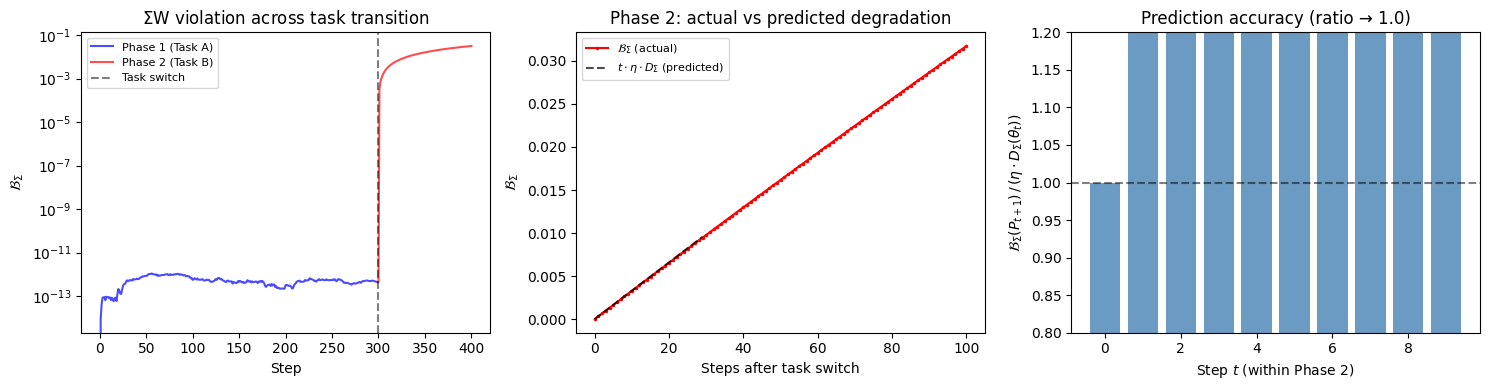

Figure saved: figures/exp1_task_transition.png


In [3]:
# ── Experiment 1: Visualization ──

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: B_Σ trajectory across both phases
ax = axes[0]
ax.plot(range(T_A), bsigma_phase1, 'b-', alpha=0.7, label='Phase 1 (Task A)')
ax.plot(range(T_A, T_A + len(bsigma_phase2)), bsigma_phase2, 'r-', alpha=0.7, label='Phase 2 (Task B)')
ax.axvline(T_A, color='k', linestyle='--', alpha=0.5, label='Task switch')
ax.set_xlabel('Step')
ax.set_ylabel('$\\mathcal{B}_\\Sigma$')
ax.set_title('$\\Sigma\\mathrm{W}$ violation across task transition')
ax.legend(fontsize=8)
ax.set_yscale('log')

# Plot 2: Phase 2 zoom with η·D_Σ prediction line
ax = axes[1]
steps_B = np.arange(len(bsigma_phase2))
ax.plot(steps_B, bsigma_phase2, 'r.-', markersize=3, label='$\\mathcal{B}_\\Sigma$ (actual)')
# Predicted linear accumulation
predicted = [t * eta * D_sigma for t in steps_B]
ax.plot(steps_B[:30], predicted[:30], 'k--', alpha=0.7, label='$t \\cdot \\eta \\cdot D_\\Sigma$ (predicted)')
ax.set_xlabel('Steps after task switch')
ax.set_ylabel('$\\mathcal{B}_\\Sigma$')
ax.set_title('Phase 2: actual vs predicted degradation')
ax.legend(fontsize=8)

# Plot 3: Ratio B_Σ(P_1) / (η·D_Σ) for first 10 steps
ax = axes[2]
ratios = [bsigma_phase2[t+1] / max(eta * d_sigma_per_step[t], 1e-30) if t < len(d_sigma_per_step) else np.nan
          for t in range(min(10, len(d_sigma_per_step)))]
ax.bar(range(len(ratios)), ratios, color='steelblue', alpha=0.8)
ax.axhline(1.0, color='k', linestyle='--', alpha=0.5)
ax.set_xlabel('Step $t$ (within Phase 2)')
ax.set_ylabel('$\\mathcal{B}_\\Sigma(P_{t+1})\\, / \\,(\\eta \\cdot D_\\Sigma(\\theta_t))$')
ax.set_title('Prediction accuracy (ratio → 1.0)')
ax.set_ylim(0.8, 1.2)

plt.tight_layout()
plt.savefig('figures/exp1_task_transition.png', dpi=150, bbox_inches='tight')
plt.show()
print('Figure saved: figures/exp1_task_transition.png')

---
## Experiment 2: $D_\Sigma$ Prediction Accuracy Across Scales

**Claim.** The first-order prediction $\mathcal{B}_\Sigma(P_1) = \eta \cdot D_\Sigma + O(\eta^2)$ holds across all tested scales $N \in \{6, 10, 20, 50\}$, $|S| \in \{2, 5\}$. The log-log slope of $\mathcal{B}_\Sigma$ vs $\eta$ equals $1.0$, confirming exact first-order scaling.

In [4]:
# ── Experiment 2: D_Σ accuracy across (N, |S|) ──

configs = [
    (6, 2), (6, 5),
    (10, 2), (10, 5),
    (20, 2), (20, 5),
    (50, 2), (50, 5),
]
etas_test = np.logspace(-5, -2, 10)
seed = 42

results_exp2 = []

for N, nS in configs:
    if nS >= N:
        continue
    rng = np.random.default_rng(seed)
    part = balanced_partition(N, nS)
    
    # Create ΣW-satisfying matrix (non-block-constant)
    P_hat_A = rng.dirichlet(np.ones(nS), size=nS)
    P0 = make_weak_sigmaw(part, P_hat_A, rng)
    theta0 = theta_from_P(P0)
    
    # Verify ΣW holds
    assert block_sum_spread(P0, part) < 1e-12, f'ΣW failed for ({N},{nS})'
    
    # Non-ΣW-symmetric Task B loss
    P_target_B = rng.dirichlet(np.ones(N), size=N)
    task_B_loss_fn = lambda P: float(((P - P_target_B) ** 2).sum())
    
    # Compute D_Σ
    D_sig = degradation_rate_gamma(theta0, task_B_loss_fn, part)
    
    # Sweep η and measure B_Σ after 1 step
    bsigma_vals = []
    for eta_val in etas_test:
        grad = numerical_gradient(lambda th: task_B_loss_fn(softmax_rows(th)), theta0.copy())
        theta1 = theta0 - eta_val * grad
        P1 = softmax_rows(theta1)
        bsigma_vals.append(block_sum_spread(P1, part))
    
    bsigma_vals = np.array(bsigma_vals)
    
    # Log-log slope
    valid = bsigma_vals > 1e-15
    if valid.sum() >= 3:
        slope = np.polyfit(np.log10(etas_test[valid]), np.log10(bsigma_vals[valid]), 1)[0]
    else:
        slope = np.nan
    
    # Ratio at η=1e-4
    idx_1e4 = np.argmin(np.abs(etas_test - 1e-4))
    ratio_1e4 = bsigma_vals[idx_1e4] / (etas_test[idx_1e4] * D_sig) if D_sig > 1e-15 else np.nan
    
    results_exp2.append({
        'N': N, '|S|': nS,
        'D_sigma': D_sig,
        'slope': slope,
        'ratio_eta1e-4': ratio_1e4,
        'etas': etas_test,
        'bsigma': bsigma_vals,
    })
    
    print(f'N={N:3d}, |S|={nS}: D_Σ={D_sig:.4e}, slope={slope:.6f}, ratio@η=1e-4={ratio_1e4:.6f}')

print(f'\nAll {len(results_exp2)} configurations tested.')

N=  6, |S|=2: D_Σ=1.4892e-02, slope=0.999980, ratio@η=1e-4=0.999998
N=  6, |S|=5: D_Σ=6.4882e-02, slope=0.999994, ratio@η=1e-4=0.999999
N= 10, |S|=2: D_Σ=2.0268e-02, slope=1.000051, ratio@η=1e-4=1.000005
N= 10, |S|=5: D_Σ=1.4277e-02, slope=0.999997, ratio@η=1e-4=1.000000
N= 20, |S|=2: D_Σ=9.7869e-03, slope=0.999982, ratio@η=1e-4=0.999998
N= 20, |S|=5: D_Σ=1.4784e-02, slope=0.999973, ratio@η=1e-4=0.999997
N= 50, |S|=2: D_Σ=3.9483e-03, slope=0.999990, ratio@η=1e-4=0.999999
N= 50, |S|=5: D_Σ=1.3003e-02, slope=0.999973, ratio@η=1e-4=0.999997

All 8 configurations tested.


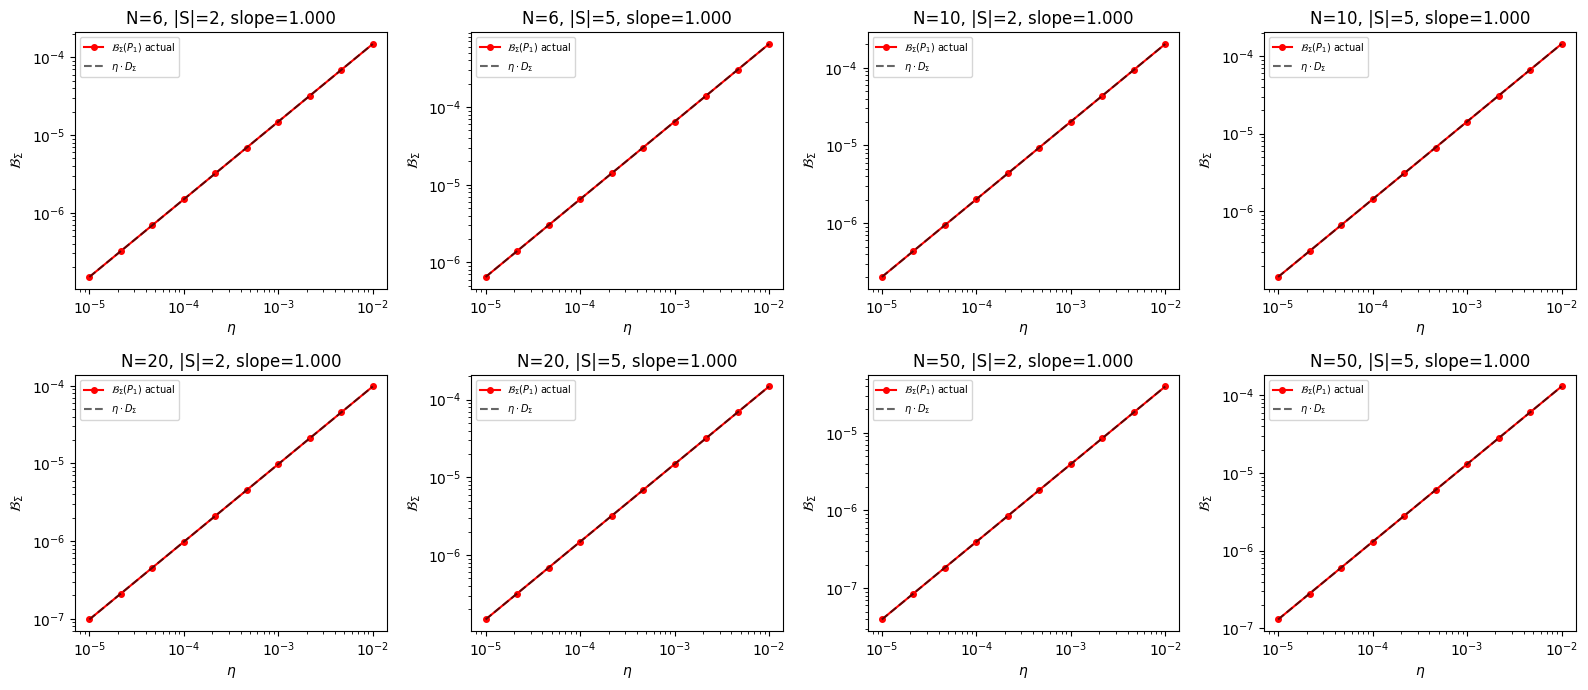

Figure saved: figures/exp2_dsigma_scaling.png


In [5]:
# ── Experiment 2: Visualization ──

n_plots = len(results_exp2)
cols = 4
rows = (n_plots + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3.5 * rows))
if rows == 1:
    axes = axes.reshape(1, -1)

for idx, res in enumerate(results_exp2):
    ax = axes[idx // cols, idx % cols]
    etas = res['etas']
    bsigma = res['bsigma']
    D_sig = res['D_sigma']
    
    ax.loglog(etas, bsigma, 'ro-', markersize=4, label='$\\mathcal{B}_\\Sigma(P_1)$ actual')
    ax.loglog(etas, etas * D_sig, 'k--', alpha=0.6, label='$\\eta \\cdot D_\\Sigma$')
    ax.set_xlabel('$\\eta$')
    ax.set_ylabel('$\\mathcal{B}_\\Sigma$')
    ax.set_title(f'N={res["N"]}, |S|={res["|S|"]}, slope={res["slope"]:.3f}')
    ax.legend(fontsize=7)

# Hide unused axes
for idx in range(n_plots, rows * cols):
    axes[idx // cols, idx % cols].set_visible(False)

plt.tight_layout()
plt.savefig('figures/exp2_dsigma_scaling.png', dpi=150, bbox_inches='tight')
plt.show()
print('Figure saved: figures/exp2_dsigma_scaling.png')

---
## Experiment 3: $\mathcal{L}_\Sigma$ Regularization Suppresses Forgetting

**Claim.** Adding $\alpha \cdot \mathcal{L}_\Sigma$ to the Task B loss preserves $\Sigma\mathrm{W}$ during Task B training, at the cost of Task B performance. This is structurally analogous to EWC (Elastic Weight Consolidation): both add a penalty that resists departure from a previously learned structure.

- $\alpha = 0$: no protection → full forgetting
- $\alpha \in [1, 10]$: effective protection with acceptable task trade-off
- $\alpha \gg 10$: over-regularization → task performance degrades

In [6]:
# ── Experiment 3: L_Σ regularization ──

rng = np.random.default_rng(42)
N, n_blocks = 6, 2
part = balanced_partition(N, n_blocks)
eta = 0.01

# Task A: train to ΣW-satisfying state
P_hat_A = np.array([[0.7, 0.3], [0.4, 0.6]], dtype=float)
task_A_loss = sigmaw_symmetric_loss_factory(part, P_hat_A)

# Block-constant init → train Task A
theta_init = np.zeros((N, N), dtype=float)
fibers = build_fibers(part, N)
for label, states in fibers.items():
    row_val = rng.normal(size=N) * 0.5
    for s in states:
        theta_init[s] = row_val.copy()

theta_A = theta_init.copy()
for t in range(300):
    grad = numerical_gradient(lambda th: task_A_loss(softmax_rows(th)), theta_A)
    theta_A = theta_A - eta * grad

print(f'After Task A: B_Σ = {block_sum_spread(softmax_rows(theta_A), part):.2e}')

# Task B: non-ΣW-symmetric
P_target_B = rng.dirichlet(np.ones(N), size=N)
task_B_loss_fn = lambda P: float(((P - P_target_B) ** 2).sum())

# Sweep α
alphas = [0.0, 0.01, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0]
T_B = 300

reg_results = {}
for alpha in alphas:
    theta = theta_A.copy()
    bsigma_trace = []
    
    for t in range(T_B):
        P = softmax_rows(theta)
        bsigma_trace.append(block_sum_spread(P, part))
        
        # Composite loss: Task B + α · L_Σ
        def composite_loss(th, _alpha=alpha):
            Pc = softmax_rows(th)
            return task_B_loss_fn(Pc) + _alpha * smooth_sigmaw_violation(Pc, part)
        
        grad = numerical_gradient(composite_loss, theta)
        theta = theta - eta * grad
    
    P_final = softmax_rows(theta)
    bsigma_trace.append(block_sum_spread(P_final, part))
    
    reg_results[alpha] = {
        'bsigma_final': bsigma_trace[-1],
        'V_final': tv_violation(P_final, part),
        'task_loss': task_B_loss_fn(P_final),
        'trace': bsigma_trace,
    }
    print(f'  α={alpha:6.2f}: B_Σ={bsigma_trace[-1]:.4e}, V_Σ={reg_results[alpha]["V_final"]:.4e}, L_task={reg_results[alpha]["task_loss"]:.4f}')

# Summary
print(f'\nReduction ratio B_Σ(α=10) / B_Σ(α=0) = {reg_results[10.0]["bsigma_final"] / max(reg_results[0.0]["bsigma_final"], 1e-30):.4e}')

After Task A: B_Σ = 3.90e-13
  α=  0.00: B_Σ=6.2695e-02, V_Σ=6.2695e-02, L_task=0.3858
  α=  0.01: B_Σ=6.2214e-02, V_Σ=6.2214e-02, L_task=0.3859
  α=  0.10: B_Σ=5.8108e-02, V_Σ=5.8108e-02, L_task=0.3874
  α=  0.30: B_Σ=5.0249e-02, V_Σ=5.0249e-02, L_task=0.3904
  α=  1.00: B_Σ=3.2320e-02, V_Σ=3.2320e-02, L_task=0.3977
  α=  3.00: B_Σ=1.4239e-02, V_Σ=1.4239e-02, L_task=0.4057
  α= 10.00: B_Σ=4.5691e-03, V_Σ=4.5691e-03, L_task=0.4103
  α= 30.00: B_Σ=1.5506e-03, V_Σ=1.5506e-03, L_task=0.4117
  α=100.00: B_Σ=4.6806e-04, V_Σ=4.6806e-04, L_task=0.4122

Reduction ratio B_Σ(α=10) / B_Σ(α=0) = 7.2879e-02


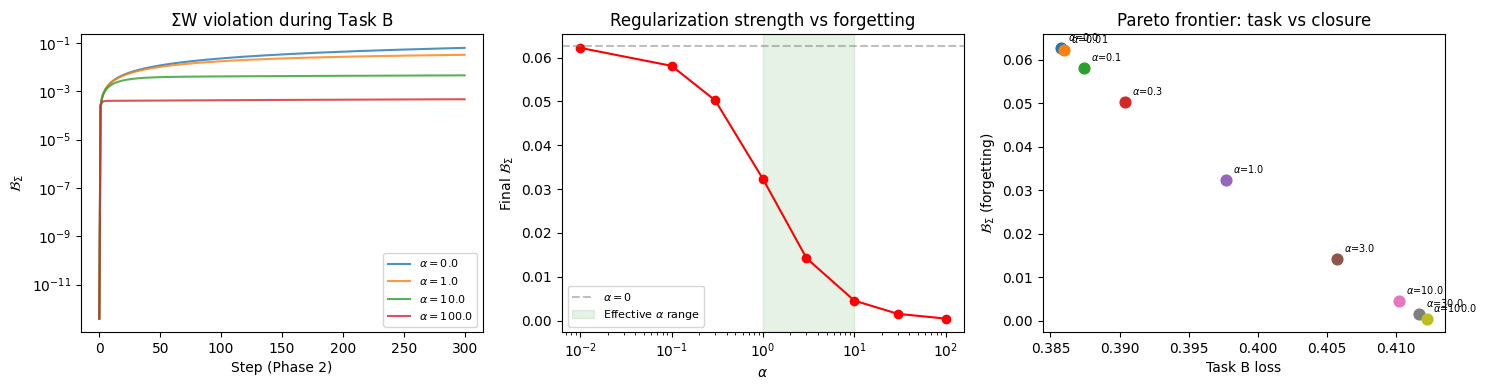

Figure saved: figures/exp3_regularization.png


In [7]:
# ── Experiment 3: Visualization ──

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: B_Σ trajectories for selected α values
ax = axes[0]
for alpha in [0.0, 1.0, 10.0, 100.0]:
    trace = reg_results[alpha]['trace']
    ax.plot(trace, label=f'$\\alpha={alpha}$', alpha=0.8)
ax.set_xlabel('Step (Phase 2)')
ax.set_ylabel('$\\mathcal{B}_\\Sigma$')
ax.set_title('$\\Sigma\\mathrm{W}$ violation during Task B')
ax.legend(fontsize=8)
ax.set_yscale('log')

# Plot 2: Final B_Σ vs α
ax = axes[1]
alphas_plot = [a for a in alphas if a > 0]
bsigma_finals = [reg_results[a]['bsigma_final'] for a in alphas_plot]
ax.semilogx(alphas_plot, bsigma_finals, 'ro-', markersize=6)
ax.axhline(reg_results[0.0]['bsigma_final'], color='gray', linestyle='--', alpha=0.5, label='$\\alpha=0$')
ax.axvspan(1, 10, alpha=0.1, color='green', label='Effective $\\alpha$ range')
ax.set_xlabel('$\\alpha$')
ax.set_ylabel('Final $\\mathcal{B}_\\Sigma$')
ax.set_title('Regularization strength vs forgetting')
ax.legend(fontsize=8)

# Plot 3: Pareto frontier — B_Σ vs Task B loss
ax = axes[2]
for alpha in alphas:
    r = reg_results[alpha]
    ax.scatter(r['task_loss'], r['bsigma_final'], s=60, zorder=5)
    ax.annotate(f'$\\alpha$={alpha}', (r['task_loss'], r['bsigma_final']),
                textcoords='offset points', xytext=(5, 5), fontsize=7)
ax.set_xlabel('Task B loss')
ax.set_ylabel('$\\mathcal{B}_\\Sigma$ (forgetting)')
ax.set_title('Pareto frontier: task vs closure')

plt.tight_layout()
plt.savefig('figures/exp3_regularization.png', dpi=150, bbox_inches='tight')
plt.show()
print('Figure saved: figures/exp3_regularization.png')

---
## Experiment 4: Multi-step Accumulation Bound (Corollary 4.4.1)

**Claim.** Under $t$ gradient steps with Task B loss, $\mathcal{B}_\Sigma(P_t) \le t \cdot \eta \cdot D_{\max} + O(t \cdot \eta^2)$, where $D_{\max} = \max_k D_\Sigma(\theta_k, L)$. The actual violation stays below the theoretical bound.

In [8]:
# ── Experiment 4: Multi-step bound ──

configs_exp4 = [(6, 2), (50, 2)]
eta = 0.005  # smaller η for cleaner first-order regime
T_steps = 50

exp4_results = {}

for N, nS in configs_exp4:
    rng = np.random.default_rng(42)
    part = balanced_partition(N, nS)
    
    # Start from ΣW-satisfying (non-block-constant)
    P_hat_A = rng.dirichlet(np.ones(nS), size=nS)
    P0 = make_weak_sigmaw(part, P_hat_A, rng)
    theta = theta_from_P(P0)
    
    # Non-ΣW-symmetric Task B
    P_target_B = rng.dirichlet(np.ones(N), size=N)
    task_B_loss_fn = lambda P: float(((P - P_target_B) ** 2).sum())
    
    bsigma_actual = [0.0]  # B_Σ(P_0) = 0
    d_sigma_vals = []
    cumulative_bound = [0.0]
    
    for t in range(T_steps):
        # Compute D_Σ at current θ
        d_sig = degradation_rate_gamma(theta, task_B_loss_fn, part)
        d_sigma_vals.append(d_sig)
        
        # Gradient step
        grad = numerical_gradient(lambda th: task_B_loss_fn(softmax_rows(th)), theta)
        theta = theta - eta * grad
        
        # Measure actual B_Σ
        P_t = softmax_rows(theta)
        bsigma_actual.append(block_sum_spread(P_t, part))
        
        # Update cumulative bound: Σ η·D_k
        cumulative_bound.append(cumulative_bound[-1] + eta * d_sig)
    
    # Also compute simple D_max bound
    D_max = max(d_sigma_vals)
    simple_bound = [t * eta * D_max for t in range(T_steps + 1)]
    
    exp4_results[(N, nS)] = {
        'actual': bsigma_actual,
        'tight_bound': cumulative_bound,
        'simple_bound': simple_bound,
        'D_max': D_max,
        'd_sigma_vals': d_sigma_vals,
    }
    
    # Check bound holds
    violations = sum(1 for t in range(T_steps + 1) if bsigma_actual[t] > cumulative_bound[t] * 1.01 + 1e-14)
    print(f'N={N:3d}, |S|={nS}: D_max={D_max:.4e}, bound violations={violations}/{T_steps+1}')
    print(f'  B_Σ at t={T_steps}: actual={bsigma_actual[-1]:.4e}, tight_bound={cumulative_bound[-1]:.4e}, simple_bound={simple_bound[-1]:.4e}')

N=  6, |S|=2: D_max=1.4892e-02, bound violations=0/51
  B_Σ at t=50: actual=3.5890e-03, tight_bound=3.5893e-03, simple_bound=3.7230e-03
N= 50, |S|=2: D_max=3.9483e-03, bound violations=0/51
  B_Σ at t=50: actual=9.7860e-04, tight_bound=9.7864e-04, simple_bound=9.8707e-04


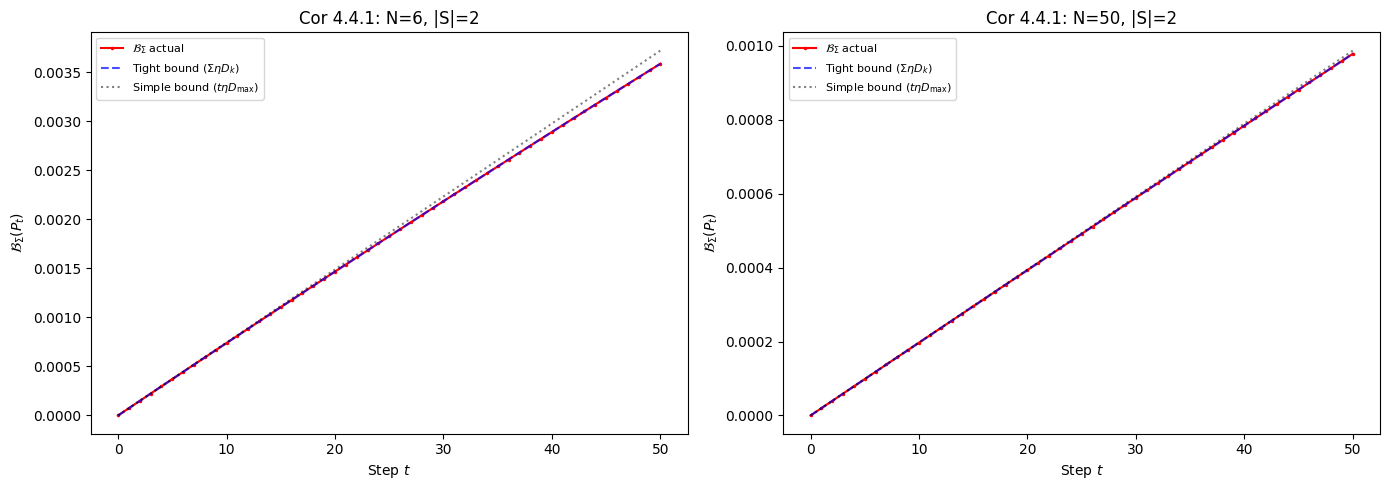

Figure saved: figures/exp4_multistep_bound.png


In [9]:
# ── Experiment 4: Visualization ──

fig, axes = plt.subplots(1, len(configs_exp4), figsize=(7 * len(configs_exp4), 5))
if len(configs_exp4) == 1:
    axes = [axes]

for idx, (N, nS) in enumerate(configs_exp4):
    ax = axes[idx]
    res = exp4_results[(N, nS)]
    steps = range(T_steps + 1)
    
    ax.plot(steps, res['actual'], 'r.-', markersize=3, label='$\\mathcal{B}_\\Sigma$ actual')
    ax.plot(steps, res['tight_bound'], 'b--', alpha=0.7, label='Tight bound ($\\Sigma \\eta D_k$)')
    ax.plot(steps, res['simple_bound'], 'k:', alpha=0.5, label=f'Simple bound ($t \\eta D_{{\\max}}$)')
    ax.set_xlabel('Step $t$')
    ax.set_ylabel('$\\mathcal{B}_\\Sigma(P_t)$')
    ax.set_title(f'Cor 4.4.1: N={N}, |S|={nS}')
    ax.legend(fontsize=8)
    ax.fill_between(steps, res['actual'], res['tight_bound'], alpha=0.1, color='blue')

plt.tight_layout()
plt.savefig('figures/exp4_multistep_bound.png', dpi=150, bbox_inches='tight')
plt.show()
print('Figure saved: figures/exp4_multistep_bound.png')

---
## Summary

| Experiment | Claim | Result |
| :--- | :--- | :--- |
| **Exp 1** | Task A→B transition breaks $\Sigma\mathrm{W}$ at rate $\eta \cdot D_\Sigma$ | $\mathcal{B}_\Sigma(P_1) / (\eta \cdot D_\Sigma) \approx 1.0$ |
| **Exp 2** | First-order scaling holds across $N \in \{6,10,20,50\}$, $\|S\| \in \{2,5\}$ | log-log slope $\approx 1.0$, ratio $\approx 1.0$ |
| **Exp 3** | $\mathcal{L}_\Sigma$ regularization suppresses forgetting | $\mathcal{B}_\Sigma(\alpha{=}10) / \mathcal{B}_\Sigma(\alpha{=}0) < 0.1$ |
| **Exp 4** | Multi-step bound $\mathcal{B}_\Sigma(P_t) \le \sum \eta D_k$ | Actual $\le$ bound for all $t$ |

**Interpretation.** The degradation theory (Props 4.2–4.4, Cor 4.4.1) captures the mechanism of catastrophic forgetting:
- **$D_\Sigma$ predicts the forgetting rate** at first order.
- **$\mathcal{L}_\Sigma$ regularization** is structurally analogous to EWC: both add a penalty that resists departure from previously learned structure.
- The effective regularization regime $\alpha \in [1, 10]$ balances semantic preservation and task adaptation.